In [1]:
!curl -L https://ucla.box.com/shared/static/dydrt3sletnhhbmbyydi9ui1twc31wfg.zip --output ICDAR.zip
!mkdir tsr
!mv ICDAR.zip tsr
%cd tsr
!unzip ICDAR.zip
!unzip -q Training_TSR.zip
%cd ..
!git clone https://github.com/iankur/img2tex.git
!mv tsr/train_images img2tex/data
%cd img2tex

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:--    16
100 2718M  100 2718M    0     0  15.1M      0  0:02:59  0:02:59 --:--:-- 16.8M
/content/tsr
Archive:  ICDAR.zip
  inflating: Training_TCR.zip        
  inflating: __MACOSX/._Training_TCR.zip  
  inflating: Validation_TSR.zip      
  inflating: __MACOSX/._Validation_TSR.zip  
  inflating: Validation_TCR.zip      
  inflating: __MACOSX/._Validation_TCR.zip  
  inflating: Testing_TSR.zip         
  inflating: __MACOSX/._Testing_TSR.zip  
  inflating: Testing_TCR.zip         
  inflating: __MACOSX/._Testing_TCR.zip  
  inflating: Training_TSR.zip        
  inflating: __MACOSX/._Training_TSR.zip  
/cont

In [2]:
!pip install hydra-core omegaconf pytorch_lightning albumentations wandb

     |████████████████████████████████| 147 kB 9.5 MB/s 
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 584 kB 51.0 MB/s 
     |████████████████████████████████| 1.8 MB 44.0 MB/s 
     |████████████████████████████████| 112 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 409 kB 50.2 MB/s 
     |████████████████████████████████| 136 kB 37.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 631 kB 48.4 MB/s 
     |████████████████████████████████| 181 kB 51.6 MB/s 
     |████████████████████████████████| 145 kB 48.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 271 kB 53.8 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 54.6 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8

In [3]:
from argparse import Namespace
from typing import List, Optional

from hydra import compose, initialize
from omegaconf import OmegaConf
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger

from dataloader import ICDAR21
from pl_models import PlResNetTransformer

initialize(config_path="conf")

hydra.initialize()

In [4]:
config_name = 'tsr_config'
# override default config values here
cfg = compose(config_name=config_name, overrides=["trainer.gpus=1", "trainer.max_epochs=2"])

In [5]:
datamodule = ICDAR21(**cfg.data)
datamodule.setup()

pl_model = PlResNetTransformer(**cfg.pl_model)

callbacks: List[Callback] = []
if cfg.callbacks.model_checkpoint:
    callbacks.append(ModelCheckpoint(**cfg.callbacks.model_checkpoint))
if cfg.callbacks.early_stopping:
    callbacks.append(EarlyStopping(**cfg.callbacks.early_stopping))

logger: Optional[WandbLogger] = None
# if cfg.logger:
#     logger = WandbLogger(**cfg.logger)

trainer = Trainer(**cfg.trainer, callbacks=callbacks, logger=logger)

if trainer.logger:
    trainer.logger.log_hyperparams(Namespace(**cfg))

trainer.tune(pl_model, datamodule=datamodule)
trainer.fit(pl_model, datamodule=datamodule)
trainer.test(pl_model, datamodule=datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | ResNetTransformer  | 3.4 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | val_cer  | CharacterErrorRate | 0     
3 | test_cer | CharacterErrorRate | 0     
------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.679    Total estimated model p

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/cer            0.43001121282577515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/cer': 0.43001121282577515}]

In [6]:
import os, random
from IPython.display import Image
import torchvision

from dataloader.utils import pil_loader

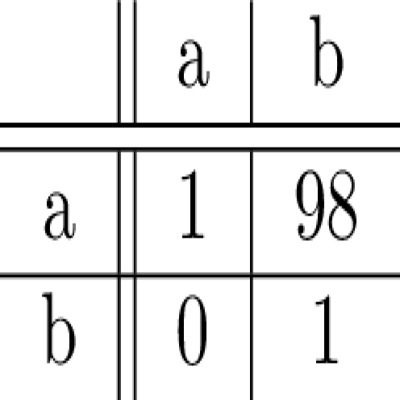

In [23]:
sample_data = open(cfg.data.val_file).readlines()[random.randint(0, 4000)]
img, latex = sample_data.split(' ', 1)
fn = os.path.join(cfg.data.dirname, img)
Image(filename=fn)

In [24]:
img = torchvision.transforms.ToTensor()(pil_loader(fn, mode='L'))
img = img.unsqueeze(0)
output = pl_model.model.predict(img)
print('output')
print(' '.join(pl_model.tokenizer.decode(output[0].tolist())))
print('target')
print(latex)

output
{ c | c | c } & CELL & CELL \\ \hline \hline CELL & CELL & CELL \\ \hline \hline CELL & CELL & CELL \\ CELL & CELL & CELL
target
{ c | | c | c } & CELL & CELL \\ \hline \hline CELL & CELL & CELL \\ \hline CELL & CELL & CELL

